In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import tensorflow probability, distributions and bijectors
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# import tensorflow
import tensorflow as tf
from IPython.core.pylabtools import figsize

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.compat.v1.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.compat.v1.OptimizerOptions.ON_1)
    return config

def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.compat.v1.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.compat.v1.InteractiveSession(config=config)

reset_sess()

Device mapping: no known devices.


Create synthetic sinusoidal dataset with noise $\epsilon \sim N(0, \sigma^2)$, with $t = y(x,w) + \epsilon$ where $y(x,w)$ is our regression model, with input data $x$ and parameter weights $w$. 

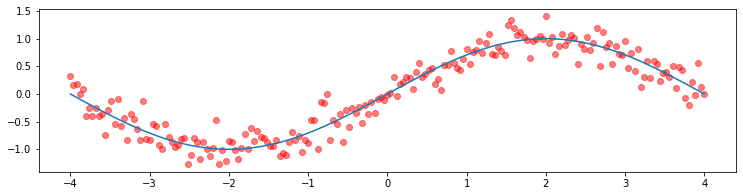

In [3]:
n_samples = 201

#np.random.seed(10)
x = tf.linspace(-4, 4, int(n_samples))                                  # linear space from 0 to l    
e = tfd.Normal(loc=0, scale=1/5).sample(n_samples, seed=10)             # noise                              
t = tf.math.sin(2*np.pi * x/8)                                          # sinusiodal function

y = tf.cast(t, dtype='float32') + e                                     # data = sinusoidal function + noise

plt.figure(figsize(12.5, 3))
plt.plot(x, t)
plt.scatter(x, y, alpha=0.5, color='red')
plt.show()

Perform Bayesian Regression via TFP, where we asign a normal destribution to the prior distribution of weights:

\begin{align*}
y(\boldsymbol{x},\boldsymbol{w}) &= \boldsymbol{w}^T \phi(\boldsymbol{x}) \\
\end{align*}

\begin{align*}
p(\boldsymbol{w} | \boldsymbol{x}, t) \propto p(t|\boldsymbol{x},\boldsymbol{w})p(\boldsymbol{w})
\end{align*}

where,

\begin{align*}
t | \boldsymbol{x}, \boldsymbol{w} &\sim \mathcal{N}(t|\boldsymbol{\Phi} \boldsymbol{w}, \beta^{-1}) \\
w &\sim \mathcal{N}(w|m_0, \boldsymbol{S_0})  \\
\end{align*}

For this demonstration we let $\boldsymbol{m_0} = 0$ and $\boldsymbol{S_0} = \frac{1}{4}\boldsymbol{I}$ be an isotropic gaussian distribution and perform polynomial regression with linear basis function given by,

\begin{equation}
\phi_j (x) = x^j
\end{equation}

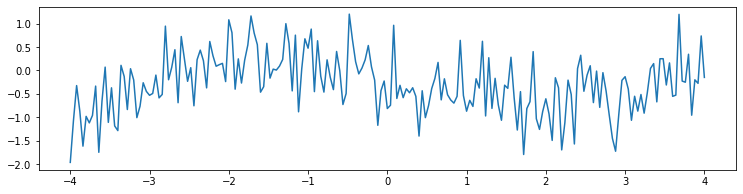

In [4]:
beta_inv = np.var(y)    
poly_degree = 4                                                                                     # sample variance of the dataset

rv_normal_w = tfd.MultivariateNormalDiag(loc=0., scale_diag=[1/4])                                  # normal data generator
normal_w = rv_normal_w.sample(poly_degree)                                                          # sample from prior

mu_ = tf.math.polyval(
    coeffs = [i for [i] in evaluate(normal_w)], 
    x = [float(i) for i in x]
)
rv_normal_t = tfd.Normal(loc=[float(i) for i in evaluate(mu_)], scale=beta_inv)                     # conditionally normal likelihood

normal_t = rv_normal_t.sample()                                                                    # sample from normal distribution

# plot
plt.plot(x, normal_t)
plt.show()

Since gaussian is a conjugate prior for the gaussian distribution the posterior distribution will also be gaussian with

\begin{equation}
p(\boldsymbol{w} | \boldsymbol{y}) = 
\mathcal{N}(\boldsymbol{w} |
    \boldsymbol{\phi}^T \boldsymbol{m}_N, \boldsymbol{\phi}^T (\boldsymbol{y}) \boldsymbol{S}_N \boldsymbol{\phi}(\boldsymbol{y}) + \sigma^2)
\end{equation}

where,

\begin{align*}
\boldsymbol{S}_N &= (\boldsymbol{S}_0^{-1} + \beta^{2} \boldsymbol{\Phi}^T \boldsymbol{\Phi})^-1 \\
\boldsymbol{m}_N &= \boldsymbol{S}_N(\boldsymbol{S}_0^{-1} \boldsymbol{m_0} + \sigma^{-2} \boldsymbol{\Phi}^T \boldsymbol{y})

\end{align*}

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


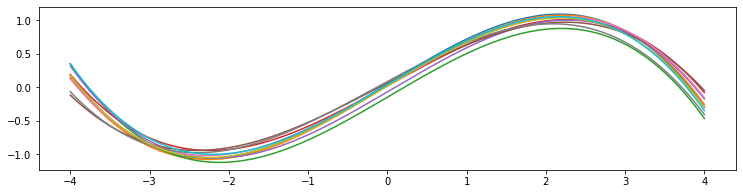

In [5]:
# define the polynomial basis function
def make_poly(x, n):
    r = np.empty([len(x), n])
    for i in range(n):
        for j in range(len(x)):
            r[j,i] = x[j]**i
    return r

Phi_ = make_poly(x, 4)    # compute feature matrix

# compute posterior distribution
S0 = (1/4) * tf.linalg.diag(np.ones(poly_degree), k=0)                      # covariance of normally distributed prior
SN = tf.linalg.inv(
    tf.linalg.inv(S0) + (1/beta_inv)**2 * tf.linalg.matmul(Phi_.T, Phi_)    # convariance of normally distributed posterior
)

mN = tf.matmul(
    SN,
    (1/beta_inv)**2*tf.matmul(Phi_.T, tf.reshape(t, [-1,1]))                      # mean of normally distributed posterior
)

result = []
plt.figure(figsize(12.5, 3))
for i in range(10):
    posterior = tfd.MultivariateNormalFullCovariance(
        loc=tf.reshape(mN, [1,-1]), 
        covariance_matrix=SN
    ).sample()                                                              # sample coefficients from posterior distribution

    [posterior_] = [evaluate(posterior)]
    result.append(posterior_)

    Phi_ = make_poly(x, 4)    # compute feature matrix

    [posterior_poly] = [tf.matmul(result[i], Phi_.T)][0]                    # plot polynomial functions with coefficients
    plt.plot(x, posterior_poly)                                             # sampled from posterior                                        

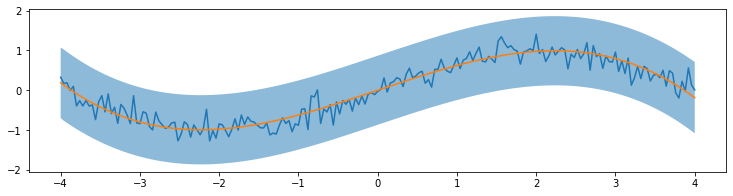

In [7]:
mu_analytical = (tf.matmul(Phi_[0].reshape(1,-1), mN))
std_analytical = tf.matmul(
                        tf.matmul(Phi_[1].reshape(1,-1), SN), 
                        Phi_[i].reshape(-1,1)
                    ) + beta_inv

for i in range(n_samples)[1:]:
    # get mu
    mu_analytical = tf.concat([mu_analytical, (tf.matmul(Phi_[i].reshape(1,-1), mN))], axis=0)

    # get std
    std_analytical = tf.concat(
        [
            std_analytical,
            tf.matmul(
            tf.matmul(Phi_[i].reshape(1,-1), SN), 
            Phi_[i].reshape(-1,1)
        ) + beta_inv
        ],
        axis=0
    )

plt.plot(x, y)
plt.plot(x, mu_analytical)

# add 95% credible interval
from scipy import stats
plt.fill_between(x, 
    tf.reshape(stats.norm.ppf(0.95, loc=mu_analytical, scale=std_analytical), [1,-1])[0],
    tf.reshape(stats.norm.ppf(0.05, loc=mu_analytical, scale=std_analytical), [1,-1])[0],
    alpha=0.5)         

plt.show()

Next, we will try using the Monte Carlo approach to see if we get similar results. The log posterior is given by:

\begin{equation}
\sum_i \log{p(\boldsymbol{w}, y_i)} = \sum_i \log{p(y_i|\boldsymbol{w})} + \log{p(\boldsymbol{w})}
\end{equation}

In [118]:
def joint_log_prob(data_, weights_):
    """
    Joint log probability optimization function.

    Args:
      weights: weight sampling
      prob_A: scalar estimate of the probability of a 1 appearing
    Returns:
      sum of the joint log probabilities from all of the prior and conditional distributions
    """ 
    poly_degree = 4                                                                                       # sample variance of the dataset

    rv_normal_w = tfd.MultivariateNormalDiag(loc=tf.zeros(poly_degree), scale_diag=(1/4)*tf.ones(poly_degree))   
    mu = tf.math.polyval(coeffs=list(weights_), x=tf.cast(x, 'float32'))
    rv_normal_t = tfd.Normal(loc=mu, scale=np.var(data_))                                                 # normal data generator
    
    
    return (
        rv_normal_w.log_prob(weights_)
        + tf.reduce_sum(input_tensor=rv_normal_t.log_prob(data_))
    )

In [204]:
number_of_steps = 20000 # 20000 #@param {type:"slider", min:2000, max:50000, step:100}
#@markdown (Default is 18000).
burnin = 2000 #1000 #@param {type:"slider", min:0, max:30000, step:100}
#@markdown (Default is 1000).
leapfrog_steps=2 #@param {type:"slider", min:1, max:9, step:1}
#@markdown (Default is 6).

# Set the chain's start state.
initial_chain_state = [
    tf.constant((0.01)*tf.ones(4), name='init_weights')
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity()   # Maps R to R.
]

# Define a closure over our joint_log_prob.
# The closure makes it so the HMC doesn't try to change the `occurrences` but
# instead determines the distributions of other parameters that might generate
# the `occurrences` we observed.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.01, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sampling from the chain.
[
    posterior_weights_
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables.
init_g = tf.compat.v1.global_variables_initializer()
init_l = tf.compat.v1.local_variables_initializer()

C:\ProgramData\Anaconda3\envs\pymc_env\lib\site-packages\tensorflow_probability\python\mcmc\internal\util.py:363: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\pymc_env\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Some issues with MCMC include poor acceptance rates, autocorrelation in the walk, correctly choosing a burn-in period

Source:
https://www.cs.cmu.edu/~epxing/Class/10708-20/scribe/lec10_scribe.pdf

In [205]:
print("Acceptance rate:", (-1)*tf.reduce_mean(kernel_results.inner_results.accepted_results[0]))

Acceptance rate: tf.Tensor(0.009586191, shape=(), dtype=float32)


In the below trace plot it looks like the weights have converged after a burn-in period of 1000:

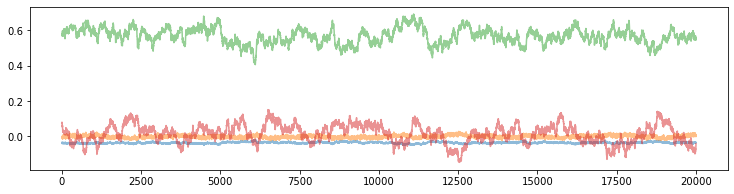

In [206]:
weight_trace = posterior_weights_

plt.figure(figsize(12.5, 3))
plt.plot(weight_trace, alpha=0.5)
plt.show()

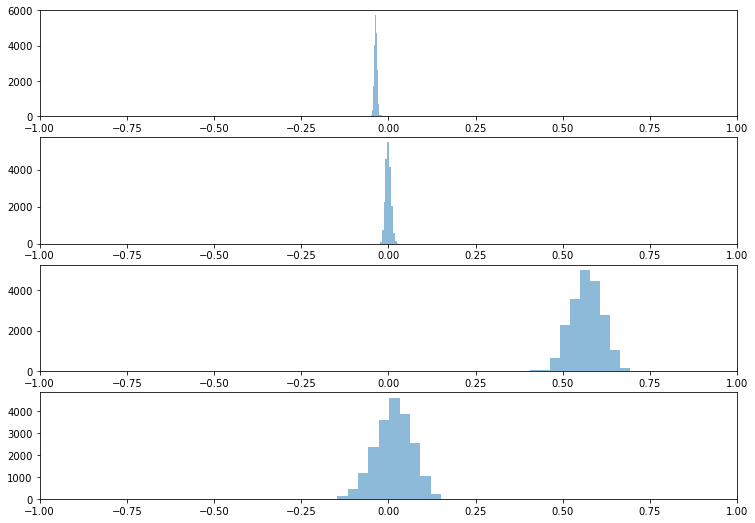

In [207]:
plt.figure(figsize(12.5, 9))
for i in range(4):
    plt.subplot(411 + i)
    plt.hist(tf.reshape(weight_trace[:, i], [1,-1]), alpha=0.5)
    plt.xlim(-1, 1)
plt.show()

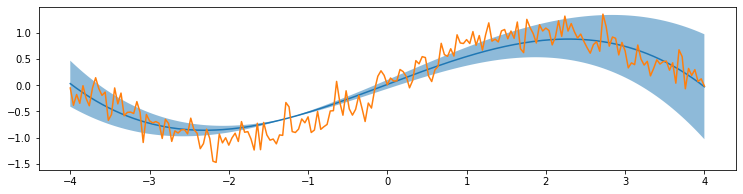

In [210]:
w_mean_ = tf.reduce_mean(posterior_weights_, axis=0)
#w = posterior_weights_[-1]
w_std_ = tf.math.reduce_std(posterior_weights_, axis=0)

posterior_mu_ = tf.math.polyval(coeffs=list(w_mean_), x=tf.cast(x, 'float32'))


plt.figure(figsize(12.5, 3))
plt.plot(x, posterior_mu_)
plt.plot(x, y)

# add 95% credible interval
from scipy import stats
plt.fill_between(x, 
    tf.math.polyval(coeffs=list(stats.norm.ppf(0.95, loc=w_mean_, scale=w_std_)), x=tf.cast(x, 'float64')),   
    tf.math.polyval(coeffs=list(stats.norm.ppf(0.05, loc=w_mean_, scale=w_std_)), x=tf.cast(x, 'float64')),
    alpha=0.5)                  

plt.show()

As we can see from the above, uncertainty in the polynomial regression model is especially high in the tail regions. We can compare the weights we got from HMC to the weights we computed using the exact analytical method:


In [267]:
print('Exact weights:', result[0][0])
print('HMC Weights:',  evaluate(w_mean_)[::-1])

Exact weights: [-0.02324466  0.70528963  0.00755194 -0.04477763]
HMC Weights: [ 0.0150772   0.5681639  -0.00093342 -0.0359727 ]


Try using a Gaussian Process Model

In [ ]:
tfd.GaussianProcessRegressionModel()